In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
import numpy as np
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import astropy.constants as c
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [176]:
srate = 4096*4
t_range=np.arange(-1,1,1/srate)

In [193]:
injected = [50, 0.2]
omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]

signal=np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
padded = qnm_filter.pad_data_for_fft(qnm_filter.RealData(signal, index=t_range), 2,2)
waveform = qnm_filter.RealData(padded[1], index=padded[0])

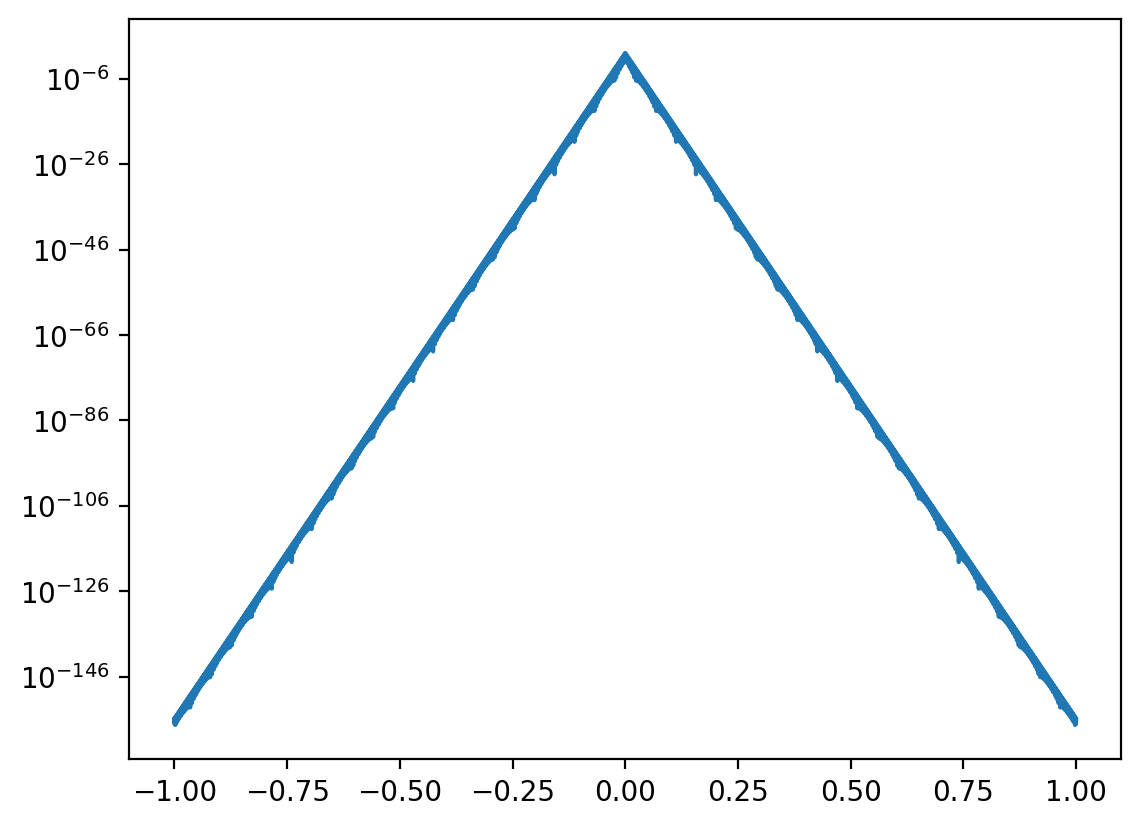

In [194]:
pl.semilogy(t_range, abs(signal))
# pl.xlim(-0.05, 0.05)

In [195]:
fit = qnm_filter.Network()
fit.original_data['H1'] = waveform
fit.add_filter(mass=injected[0], chi=injected[1], 
               model_list = [(2, 2, 0,'p')])

Text(0, 0.5, 'linear scale')

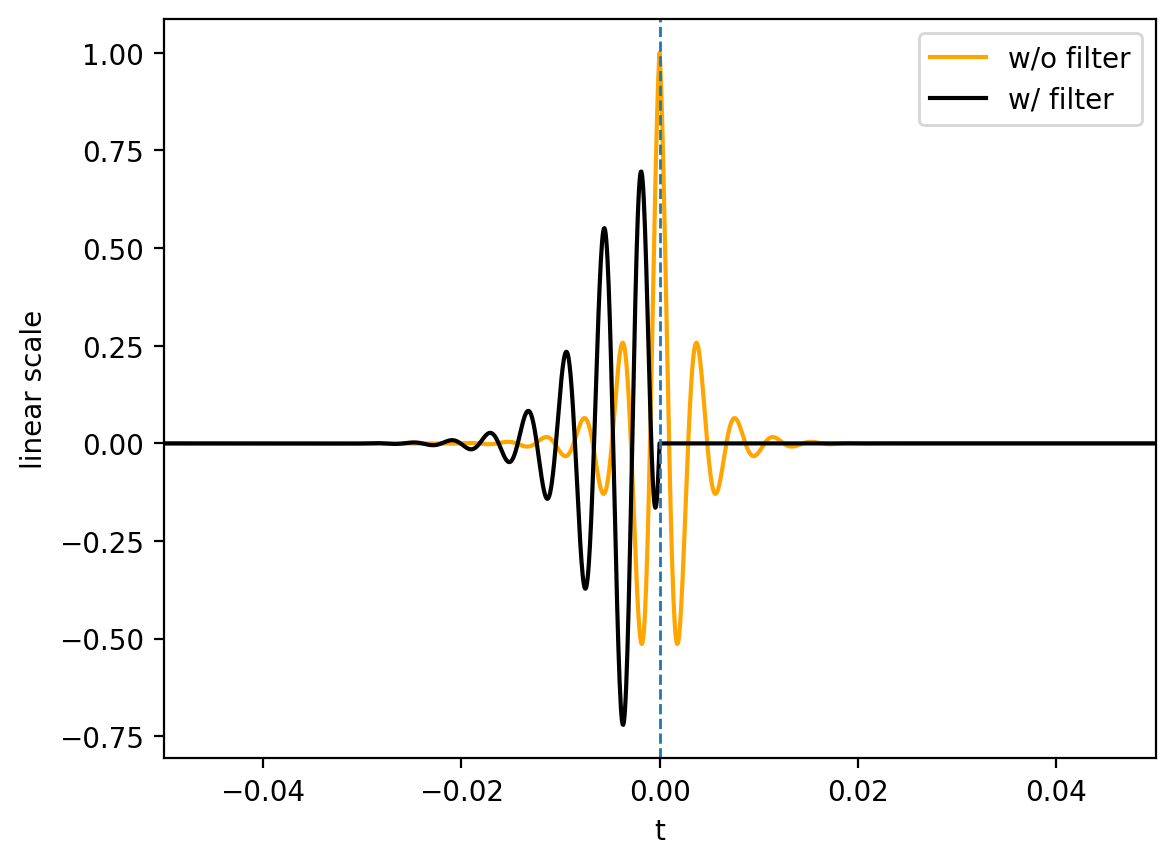

In [196]:
fit.original_data['H1'].plot(color='orange',label='w/o filter')
fit.filtered_data['H1'].plot(color='k',label='w/ filter')
pl.axvline(x=0, ls='--',lw=1)
# pl.axvline(x=tau220, ls='--',lw=1)
pl.xlim(-0.05, 0.05)
pl.legend()
pl.xlabel('t')
pl.ylabel('linear scale')
# pl.savefig('ringup_ringdown/ringup_ringdown.pdf',bbox_inches='tight')

(1e-29, 1e-21)

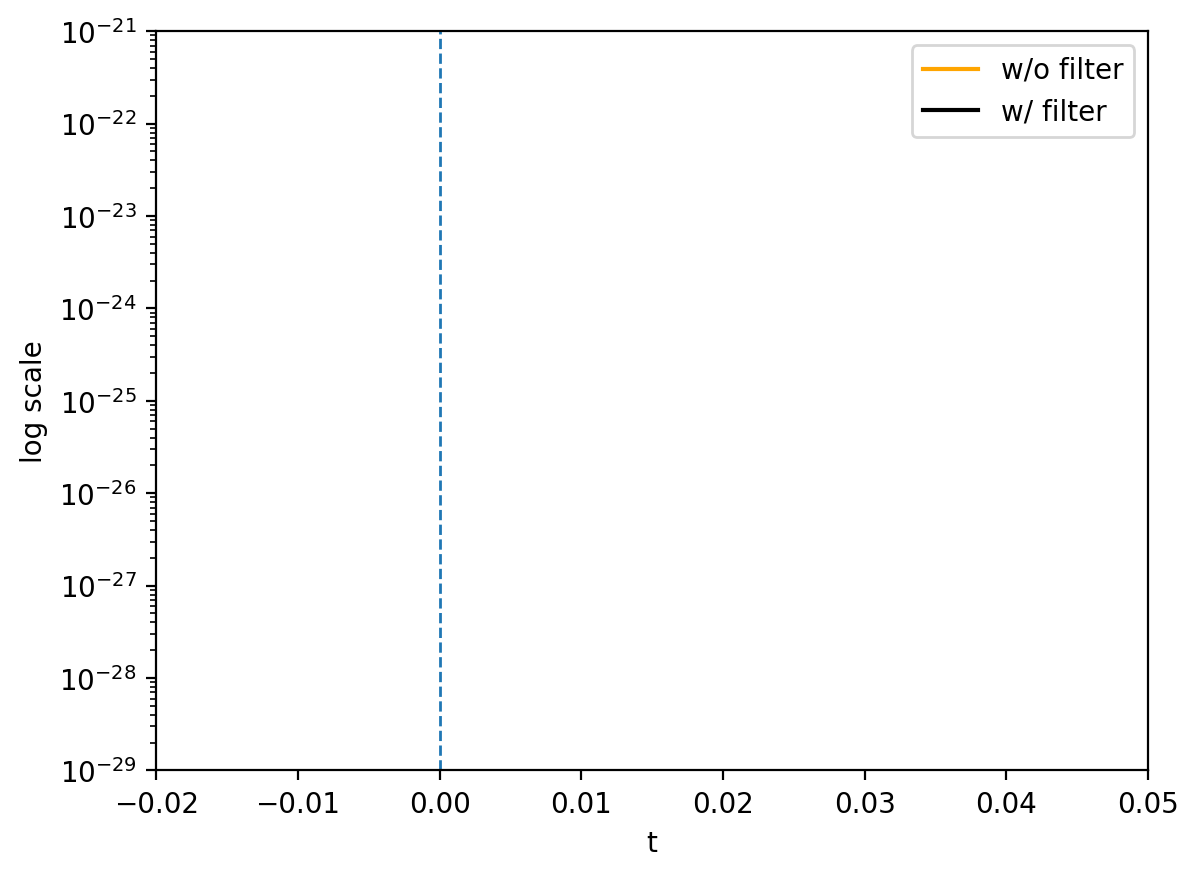

In [197]:
pl.semilogy(t_range,abs(signal),color='orange',label='w/o filter')
pl.semilogy(fit.filtered_data['H1'].index,abs(fit.filtered_data['H1'].values),
            color='k',label='w/ filter')
pl.axvline(x=0, ls='--',lw=1)
pl.legend()
pl.xlabel('t')
pl.ylabel('log scale')
pl.xlim(-0.02,0.05)
pl.ylim(1e-29,1e-21)

In [198]:
mass = qnm_filter.Filter.mass_unit(injected[0])

input = dict(model_list = [(2,2,0, 'p')], #l, m, n
             # trucation time (geocenter, in second)
             t_init = 0*mass, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = srate,
             # sky localization
             ra = None, dec = None,
             # lower limit of the high-pass filter (in Hz)
             flow = 0)

fit = qnm_filter.Network(**input)
fit.original_data['H1'] = waveform
fit.detector_alignment()
# DO NOT CONDITION DATA
fit.compute_acfs('original_data')

In [200]:
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 0.1**2
fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()
fit.first_index()

In [201]:
# # Just for verification
# fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,2,0,'p')])
# pl.semilogy(fit.original_data['H1'].index,abs(fit.original_data['H1'].values),
#             color='orange',label='w/o filter')
# pl.semilogy(fit.filtered_data['H1'].index,abs(fit.filtered_data['H1'].values),
#             color='k',label='w/ filter')
# pl.legend()
# pl.xlim(-0.02,0.05)
# pl.ylim(1e-29,1e-21)

## Pointwise

In [202]:
# Here the null hypothesis is no signal. So the FF is 0

template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
filt_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])
nofilt_likelihood = fit.compute_likelihood(apply_filter=False)

np.isclose(filt_likelihood-nofilt_likelihood, SNR**2/2)

True

In [203]:
# H0 = 220, H1 = 221. Calculate the FF from the residual SNR

template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,2,1,'p')])
template_res = fit.truncate_data(fit.filtered_data)['H1']
SNR_res = fit.compute_SNR(None, template_res, 'H1', optimal=True)
FF = np.sqrt(1-SNR_res**2/SNR**2)

filt221_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])
filt220_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])

np.isclose(filt220_likelihood - filt221_likelihood, (1-FF**2)*SNR**2/2)

True

In [204]:
pi = np.pi
w220, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])
w221, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])
filt = (w221-w220)/(w221-np.conj(w220))*(w221+np.conj(w220))/(w221+w220)
B = np.abs(filt)
phi = np.arccos(np.real(filt))
print(SNR_res**2/(SNR**2*B**2))

1.1290175939653717


In [205]:
f220 = np.real(w220)/(2*pi) / qnm_filter.Filter.mass_unit(injected[0])
tau220 = -1/np.imag(w220) * qnm_filter.Filter.mass_unit(injected[0])
wt = tau220*f220*2*pi
np.abs(1+wt**2+np.cos(2*phi)+wt*np.sin(2*phi))/(2+wt**2)

1.0983265144228813

In [208]:
t_range1 = template_res.index
test = np.real(np.exp(-1j*omega220*abs(t_range1)/(injected[0]*T_MSUN)))
theoretical_signal = B*np.real(np.exp(-(1j*omega220*t_range1+1j*phi)/(injected[0]*T_MSUN)))
SNR_temp = fit.compute_SNR(None, theoretical_signal, 'H1', optimal=True)
print(SNR_temp**2/(SNR**2*B**2))

1.1243120543251157


In [209]:
SNR_res**2/(SNR**2*B**2) - SNR_temp**2/(SNR**2*B**2)

0.004705539640255996

In [226]:
w220, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])
w221, _, _ = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])
filt = (w221-w220)/(w221-np.conj(w220))*(w221+np.conj(w220))/(w221+w220)
test_filt = qnm_filter.Filter(chi=injected[1], mass=injected[0], model_list=[(2,2,1,'p')])
print(test_filt.single_filter(w221, 2, 2, 0))
print(filt)

(0.4720370754537618+0.06626456647918424j)
(0.4720370754537618+0.06626456647918426j)


In [221]:
filt

(0.4720370754537618+0.06626456647918426j)

In [ ]:
self.neg_filter(normalized_freq, l, m, n) * self.pos_filter(
            normalized_freq, l, m, n
        )

/tmp/ipykernel_24045/1489245976.py:6: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  pl.ylim(0.05, 0.05)


(0.0475, 0.052500000000000005)

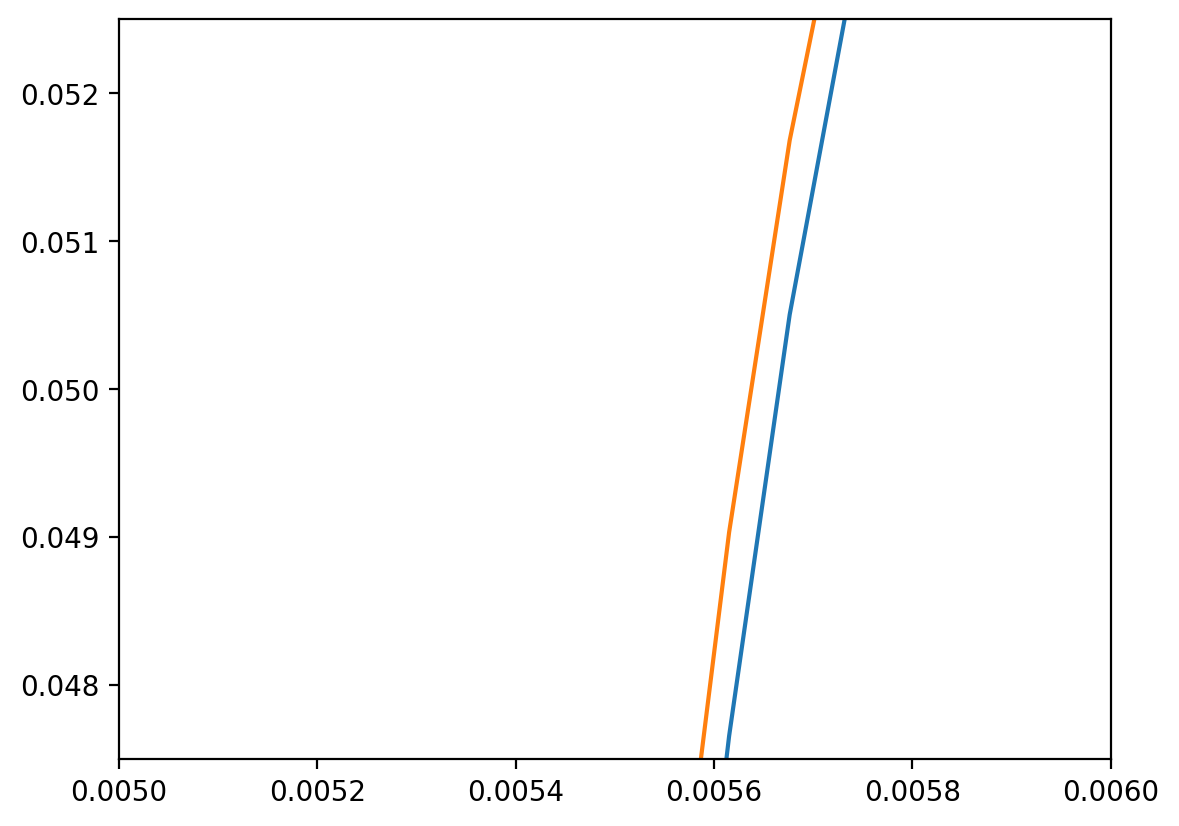

In [231]:
fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,2,1,'p')])
fit.filtered_data['H1'].plot()
pl.plot(t_range1, theoretical_signal)
# fit.original_data['H1'].plot()
pl.xlim(0.005, 0.006)
pl.ylim(0.05, 0.05)

In [93]:
FF

0.8622504972201719

In [22]:
1/((1+wt**2+np.cos(2*phi)- wt*np.sin(2*phi))/(2+wt**2))

1.0602708367803015

In [23]:
np.cos(2*phi)

0.9613485947032812

In [24]:
f220

259.8864433035151

In [25]:
tau220

0.0027887135676945038

In [26]:
# H0 = 220, H1 = 210. Calculate the FF from the residual SNR

template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,1,0,'p')])
template_210 = fit.truncate_data(fit.filtered_data)['H1']
SNR_210 = fit.compute_SNR(None, template_210, 'H1', optimal=True)
FF = np.sqrt(1-SNR_210**2/SNR**2)

filt210_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,1,0,'p')])
filt220_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])

np.isclose(filt220_likelihood - filt210_likelihood, (1-FF**2)*SNR**2/2)

True

In [27]:
# H0 = 210, H1 = 221. Calculate the FF from the residual SNR

fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,1,0,'p')])
template_210 = fit.truncate_data(fit.filtered_data)['H1']
SNR_210 = fit.compute_SNR(None, template_210, 'H1', optimal=True)
fit.add_filter(mass=injected[0], chi=injected[1], model_list=[(2,2,1,'p')])
template_221 = fit.truncate_data(fit.filtered_data)['H1']
SNR_221 = fit.compute_SNR(None, template_221, 'H1', optimal=True)
FF = np.sqrt(1-SNR_210**2/SNR_221**2)

filt221_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,1,'p')])
filt210_likelihood = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,1,0,'p')])

np.isclose(filt221_likelihood - filt210_likelihood, 0.5*(SNR_210**2 - SNR_221**2))

True

## Evidence

In [89]:
likelihood = {}
evidence = {}
credible = {}
res_template = {}
res_SNR = {}
FF = {}
occams = {}
ln_BF = {}
delta_occams = {}

In [90]:
delta_mass = 0.2
delta_chi = 0.005
massspace = np.arange(10, 80, delta_mass)
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)
fit.first_index()

### 220 vs 221

In [91]:
H0 = [(2,2,0,'p')]
H1 = [(2,2,1,'p')]
H0_set = frozenset([int(''.join([str(i) for i in j[0:3]])) for j in H0])
H1_set = frozenset([int(''.join([str(i) for i in j[0:3]])) for j in H1])

In [92]:
#H0
likelihood_temp, evidence_temp = qnm_filter.parallel_compute(fit, massspace, chispace, 
                                                             num_cpu = 9, model_list=H0)
credible_temp = qnm_filter.find_credible_region(likelihood_temp, target_probability=0.95)
likelihood[H0_set] = likelihood_temp
evidence[H0_set] = evidence_temp
credible[H0_set] = credible_temp
occams[H0_set] = (np.count_nonzero(likelihood_temp>credible_temp)/len(mass_grid.flatten()))

template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(None, template, 'H1', optimal=True)

In [93]:
#H1
likelihood_temp, evidence_temp = qnm_filter.parallel_compute(fit, massspace, chispace, 
                                                             num_cpu = 9, model_list=H1)
credible_temp = qnm_filter.find_credible_region(likelihood_temp, target_probability=0.95)
likelihood[H1_set] = likelihood_temp
evidence[H1_set] = evidence_temp
credible[H1_set] = credible_temp

ML_mass = mass_grid.flatten()[np.argmax(likelihood[H1_set])]
ML_chi = chi_grid.flatten()[np.argmax(likelihood[H1_set])]
fit.add_filter(mass=ML_mass, chi=ML_chi, model_list=H1)
res_template[H1_set] = fit.truncate_data(fit.filtered_data)['H1']
res_SNR[H1_set] = fit.compute_SNR(None, res_template[H1_set], 'H1', optimal=True)
FF[H1_set] = np.sqrt(1-res_SNR[H1_set]**2/SNR**2)

occams[H1_set] = (np.count_nonzero(likelihood[H1_set]>credible[H1_set])/len(mass_grid.flatten()))
ln_BF[H1_set] = evidence[H0_set] - evidence[H1_set]
delta_occams[H1_set] = np.log(occams[H0_set]) - np.log(occams[H1_set])

KeyboardInterrupt: 

In [ ]:
print((1-FF[H1_set]**2)*SNR**2/2+delta_occams[H1_set])
print(ln_BF[H1_set])

### 220 vs 210

In [ ]:
H1 = [(2,1,0,'p')]
H1_set = frozenset([int(''.join([str(i) for i in j[0:3]])) for j in H1])

In [ ]:
#H1
likelihood_temp, evidence_temp = qnm_filter.parallel_compute(fit, massspace, chispace, 
                                                             num_cpu = 9, model_list=H1)
credible_temp = qnm_filter.find_credible_region(likelihood_temp, target_probability=0.95)
likelihood[H1_set] = likelihood_temp
evidence[H1_set] = evidence_temp
credible[H1_set] = credible_temp

ML_mass = mass_grid.flatten()[np.argmax(likelihood[H1_set])]
ML_chi = chi_grid.flatten()[np.argmax(likelihood[H1_set])]
fit.add_filter(mass=ML_mass, chi=ML_chi, model_list=H1)
res_template[H1_set] = fit.truncate_data(fit.filtered_data)['H1']
res_SNR[H1_set] = fit.compute_SNR(None, res_template[H1_set], 'H1', optimal=True)
FF[H1_set] = np.sqrt(1-res_SNR[H1_set]**2/SNR**2)

occams[H1_set] = (np.count_nonzero(likelihood[H1_set]>credible[H1_set])/len(mass_grid.flatten()))
ln_BF[H1_set] = evidence[H0_set] - evidence[H1_set]
delta_occams[H1_set] = np.log(occams[H0_set]) - np.log(occams[H1_set])

In [ ]:
print((1-FF[H1_set]**2)*SNR**2/2+delta_occams[H1_set])
print(ln_BF[H1_set])

## 220 vs 221+210

In [332]:
H1 = [(2,2,1,'p'), (2,1,0,'p')]
H1_set = frozenset([int(''.join([str(i) for i in j[0:3]])) for j in H1])

In [333]:
# H0 = 220, H1 = 221+210. Calculate the FF from the residual SNR
fit.first_index()
likelihood_temp, evidence_temp = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, 
                                          model_list=H1)
credible_temp = qnm_filter.find_credible_region(likelihood_temp, target_probability=0.95)
likelihood[H1_set] = likelihood_temp
evidence[H1_set] = evidence_temp
credible[H1_set] = credible_temp

In [337]:
ML_mass = mass_grid.flatten()[np.argmax(likelihood[H1_set])]
ML_chi = chi_grid.flatten()[np.argmax(likelihood[H1_set])]
fit.add_filter(mass=ML_mass, chi=ML_chi, model_list=H1)
res_template[H1_set] = fit.truncate_data(fit.filtered_data)['H1']
res_SNR[H1_set] = fit.compute_SNR(None, res_template[H1_set], 'H1', optimal=True)
FF[H1_set] = np.sqrt(1-res_SNR[H1_set]**2/SNR**2)

occams[H1_set] = (np.count_nonzero(likelihood[H1_set]>credible[H1_set])/len(mass_grid.flatten()))
ln_BF[H1_set] = evidence220 - evidence[H1_set]
delta_occams[H1_set] = np.log(occams220) - np.log(occams[H1_set])

In [338]:
print((1-FF[H1_set]**2)*SNR**2/2+delta_occams[H1_set])
print(ln_BF[H1_set])

-1.015538071764014
-0.899827841258503


In [347]:
delta_occams[H1_set]

-1.0286537000611995